In [16]:
import numpy as np

file_path = "../dataset/1/1.rec"  # Update path if needed

try:
    data = np.fromfile(file_path, dtype=np.float32)  # Adjust dtype if needed
    print("Loaded .rec file successfully! Shape:", data.shape)
except Exception as e:
    print("Error reading .rec file:", e)


Loaded .rec file successfully! Shape: (35971280,)


In [17]:
fs = 25  # Sampling rate
segment_length = 30 * fs  # 30s → 750 samples

# Trim excess samples to fit full epochs
required_samples = (len(data) // segment_length) * segment_length
data = data[:required_samples]

# Reshape into 30s segments
segments = data.reshape(-1, segment_length)
print("Segmented Data Shape:", segments.shape)  # Expected: (num_epochs, 750)


Segmented Data Shape: (47961, 750)


In [18]:
labels = np.loadtxt("../dataset/1/1_1.txt", dtype=int)
print("Loaded Labels Shape:", labels.shape)


Loaded Labels Shape: (880,)


In [19]:
fs = 25  # Sampling rate
segment_length = 30 * fs  # 30 seconds → 750 samples

# Keep only enough samples for 880 epochs
required_samples = 880 * segment_length
data = data[:required_samples]  # Trim excess samples

# Reshape into (880, 750)
segments = data.reshape(-1, segment_length)

print("Corrected Data Shape:", segments.shape)  # Expected: (880, 750)


Corrected Data Shape: (880, 750)


In [20]:
print("Data Shape:", segments.shape)  # Should be (880, 750)
print("Labels Shape:", labels.shape)  # Should be (880,)


Data Shape: (880, 750)
Labels Shape: (880,)


In [21]:
apnea_labels = np.copy(labels)
apnea_labels[np.isin(labels, [0, 2, 3])] = 0  # Normal: W, N2, N3
apnea_labels[np.isin(labels, [1])] = 1  # OSA: N1
apnea_labels[np.isin(labels, [5])] = 2  # CSA: REM


In [22]:
from scipy.signal import butter, filtfilt

def butter_lowpass_filter(data, cutoff=0.5, fs=25, order=4):
    nyq = 0.5 * fs
    normal_cutoff = cutoff / nyq
    b, a = butter(order, normal_cutoff, btype='low', analog=False)
    return filtfilt(b, a, data)

filtered_segments = np.array([butter_lowpass_filter(seg) for seg in segments])
print("Filtered Data Shape:", filtered_segments.shape)


c:\Users\Victus\AppData\Local\Programs\Python\Python311\Lib\site-packages\scipy\signal\_signaltools.py:2177: RuntimeWarning: invalid value encountered in cast
  return _sigtools._linear_filter(b, a, x, axis, zi)
c:\Users\Victus\AppData\Local\Programs\Python\Python311\Lib\site-packages\scipy\signal\_arraytools.py:103: RuntimeWarning: invalid value encountered in subtract
  ext = np.concatenate((2 * left_end - left_ext,
c:\Users\Victus\AppData\Local\Programs\Python\Python311\Lib\site-packages\scipy\signal\_arraytools.py:105: RuntimeWarning: invalid value encountered in subtract
  2 * right_end - right_ext),
c:\Users\Victus\AppData\Local\Programs\Python\Python311\Lib\site-packages\scipy\signal\_arraytools.py:105: RuntimeWarning: invalid value encountered in multiply
  2 * right_end - right_ext),
c:\Users\Victus\AppData\Local\Programs\Python\Python311\Lib\site-packages\scipy\signal\_arraytools.py:103: RuntimeWarning: overflow encountered in multiply
  ext = np.concatenate((2 * left_end - l

Filtered Data Shape: (880, 750)


In [23]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, MaxPooling1D, LSTM, Dense, Dropout, BatchNormalization
from tensorflow.keras.optimizers import Adam
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

# Normalize data
filtered_segments = np.expand_dims(StandardScaler().fit_transform(filtered_segments), axis=-1)

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(filtered_segments, apnea_labels, test_size=0.2, random_state=42, stratify=apnea_labels)

# Build CNN-LSTM Model
def build_model(input_shape):
    model = Sequential([
        Conv1D(filters=32, kernel_size=3, activation='relu', input_shape=input_shape),
        BatchNormalization(),
        MaxPooling1D(pool_size=2),
        Conv1D(filters=64, kernel_size=3, activation='relu'),
        BatchNormalization(),
        MaxPooling1D(pool_size=2),
        LSTM(64, return_sequences=True),
        LSTM(32),
        Dropout(0.3),
        Dense(64, activation='relu'),
        Dense(3, activation='softmax')  # 3 classes: Normal, OSA, CSA
    ])
    
    model.compile(optimizer=Adam(learning_rate=0.001), loss='sparse_categorical_crossentropy', metrics=['accuracy'])
    return model

# Train the model
model = build_model(input_shape=(750, 1))  # 30s * 25Hz = 750 samples
history = model.fit(X_train, y_train, epochs=30, batch_size=16, validation_data=(X_test, y_test))


c:\Users\Victus\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/30
44/44 ━━━━━━━━━━━━━━━━━━━━ 9s 91ms/step - accuracy: 0.7470 - loss: 0.8003 - val_accuracy: 0.7841 - val_loss: 0.6666
Epoch 2/30
44/44 ━━━━━━━━━━━━━━━━━━━━ 3s 76ms/step - accuracy: 0.7897 - loss: 0.6642 - val_accuracy: 0.7841 - val_loss: 0.6666
Epoch 3/30
44/44 ━━━━━━━━━━━━━━━━━━━━ 3s 76ms/step - accuracy: 0.7747 - loss: 0.6957 - val_accuracy: 0.7841 - val_loss: 0.6668
Epoch 4/30
44/44 ━━━━━━━━━━━━━━━━━━━━ 3s 76ms/step - accuracy: 0.7809 - loss: 0.6648 - val_accuracy: 0.7841 - val_loss: 0.6688
Epoch 5/30
44/44 ━━━━━━━━━━━━━━━━━━━━ 3s 77ms/step - accuracy: 0.8098 - loss: 0.6113 - val_accuracy: 0.7841 - val_loss: 0.6812
Epoch 6/30
44/44 ━━━━━━━━━━━━━━━━━━━━ 3s 76ms/step - accuracy: 0.7922 - loss: 0.6681 - val_accuracy: 0.7841 - val_loss: 0.6674
Epoch 7/30
44/44 ━━━━━━━━━━━━━━━━━━━━ 3s 75ms/step - accuracy: 0.7855 - loss: 0.6692 - val_accuracy: 0.7841 - val_loss: 0.6667
Epoch 8/30
44/44 ━━━━━━━━━━━━━━━━━━━━ 3s 76ms/step - accuracy: 0.7802 - loss: 0.6826 - val_accuracy: 0.7841 - v

In [24]:
import numpy as np

# Get model predictions
y_pred_probs = model.predict(X_test)  # Get probability distributions
y_pred = np.argmax(y_pred_probs, axis=1)  # Convert to class labels


6/6 ━━━━━━━━━━━━━━━━━━━━ 2s 168ms/step


In [25]:
from sklearn.metrics import classification_report, accuracy_score

# Print classification report
print("Classification Report:\n", classification_report(y_test, y_pred, target_names=["Normal", "OSA", "CSA"]))

# Compute accuracy
accuracy = accuracy_score(y_test, y_pred)
print("Model Accuracy:", accuracy)


Classification Report:
               precision    recall  f1-score   support

      Normal       0.78      1.00      0.88       138
         OSA       0.00      0.00      0.00        15
         CSA       0.00      0.00      0.00        23

    accuracy                           0.78       176
   macro avg       0.26      0.33      0.29       176
weighted avg       0.61      0.78      0.69       176

Model Accuracy: 0.7840909090909091


c:\Users\Victus\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\Victus\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\Victus\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average,

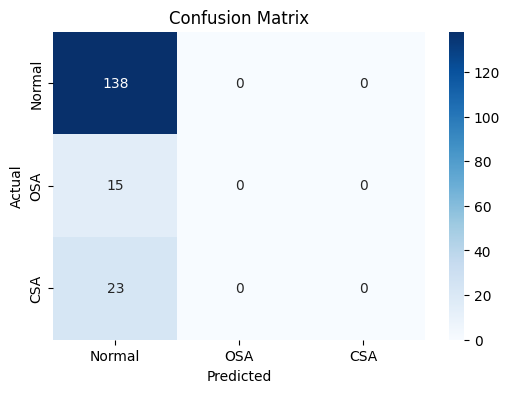

In [26]:
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

# Compute confusion matrix
cm = confusion_matrix(y_test, y_pred)

# Plot confusion matrix
plt.figure(figsize=(6, 4))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=["Normal", "OSA", "CSA"], yticklabels=["Normal", "OSA", "CSA"])
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()


main


In [15]:
import numpy as np

file_path = "../data/ISRUC_S3/RawData/RawData/1/1.rec"  # Update path if needed

try:
    data = np.fromfile(file_path, dtype=np.float32)  # Adjust dtype if needed
    print("Loaded .rec file successfully! Shape:", data.shape)
except Exception as e:
    print("Error reading .rec file:", e)


Loaded .rec file successfully! Shape: (38996030,)


In [16]:
fs = 25  # Sampling rate
segment_length = 30 * fs  # 30s → 750 samples

# Trim excess samples to fit full epochs
required_samples = (len(data) // segment_length) * segment_length
data = data[:required_samples]

# Reshape into 30s segments
segments = data.reshape(-1, segment_length)
print("Segmented Data Shape:", segments.shape)  # Expected: (num_epochs, 750)


Segmented Data Shape: (51994, 750)


In [20]:
labels = np.loadtxt("../data/ISRUC_S3/RawData/RawData/1/1_1.txt", dtype=int)
labels=labels[:794]
print("Loaded Labels Shape:", labels.shape)


Loaded Labels Shape: (794,)


In [21]:
fs = 25  # Sampling rate
segment_length = 30 * fs  # 30 seconds → 750 samples

# Keep only enough samples for 880 epochs
required_samples = 794 * segment_length
data = data[:required_samples]  # Trim excess samples

# Reshape into (880, 750)
segments = data.reshape(-1, segment_length)

print("Corrected Data Shape:", segments.shape)  # Expected: (880, 750)


Corrected Data Shape: (794, 750)


In [22]:
print("Data Shape:", segments.shape)  # Should be (880, 750)
print("Labels Shape:", labels.shape)  # Should be (880,)


Data Shape: (794, 750)
Labels Shape: (794,)


In [23]:
apnea_labels = np.copy(labels)
apnea_labels[np.isin(labels, [0, 2, 3])] = 0  # Normal: W, N2, N3
apnea_labels[np.isin(labels, [1])] = 1  # OSA: N1
apnea_labels[np.isin(labels, [5])] = 2  # CSA: REM


In [24]:
from scipy.signal import butter, filtfilt

def butter_lowpass_filter(data, cutoff=0.5, fs=25, order=4):
    nyq = 0.5 * fs
    normal_cutoff = cutoff / nyq
    b, a = butter(order, normal_cutoff, btype='low', analog=False)
    return filtfilt(b, a, data)

filtered_segments = np.array([butter_lowpass_filter(seg) for seg in segments])
print("Filtered Data Shape:", filtered_segments.shape)


c:\Users\Victus\AppData\Local\Programs\Python\Python311\Lib\site-packages\scipy\signal\_signaltools.py:2177: RuntimeWarning: invalid value encountered in cast
  return _sigtools._linear_filter(b, a, x, axis, zi)
c:\Users\Victus\AppData\Local\Programs\Python\Python311\Lib\site-packages\scipy\signal\_arraytools.py:103: RuntimeWarning: invalid value encountered in multiply
  ext = np.concatenate((2 * left_end - left_ext,
c:\Users\Victus\AppData\Local\Programs\Python\Python311\Lib\site-packages\scipy\signal\_arraytools.py:105: RuntimeWarning: overflow encountered in multiply
  2 * right_end - right_ext),
c:\Users\Victus\AppData\Local\Programs\Python\Python311\Lib\site-packages\scipy\signal\_arraytools.py:105: RuntimeWarning: invalid value encountered in subtract
  2 * right_end - right_ext),
c:\Users\Victus\AppData\Local\Programs\Python\Python311\Lib\site-packages\scipy\signal\_arraytools.py:103: RuntimeWarning: invalid value encountered in subtract
  ext = np.concatenate((2 * left_end - l

Filtered Data Shape: (794, 750)


In [25]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, MaxPooling1D, LSTM, Dense, Dropout, BatchNormalization
from tensorflow.keras.optimizers import Adam
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

# Normalize data
filtered_segments = np.expand_dims(StandardScaler().fit_transform(filtered_segments), axis=-1)

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(filtered_segments, apnea_labels, test_size=0.2, random_state=42, stratify=apnea_labels)

# Build CNN-LSTM Model
def build_model(input_shape):
    model = Sequential([
        Conv1D(filters=32, kernel_size=3, activation='relu', input_shape=input_shape),
        BatchNormalization(),
        MaxPooling1D(pool_size=2),
        Conv1D(filters=64, kernel_size=3, activation='relu'),
        BatchNormalization(),
        MaxPooling1D(pool_size=2),
        LSTM(64, return_sequences=True),
        LSTM(32),
        Dropout(0.3),
        Dense(64, activation='relu'),
        Dense(3, activation='softmax')  # 3 classes: Normal, OSA, CSA
    ])
    
    model.compile(optimizer=Adam(learning_rate=0.001), loss='sparse_categorical_crossentropy', metrics=['accuracy'])
    return model

# Train the model
model = build_model(input_shape=(750, 1))  # 30s * 25Hz = 750 samples
history = model.fit(X_train, y_train, epochs=30, batch_size=16, validation_data=(X_test, y_test))


c:\Users\Victus\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/30
40/40 ━━━━━━━━━━━━━━━━━━━━ 9s 89ms/step - accuracy: 0.7448 - loss: 0.8133 - val_accuracy: 0.7799 - val_loss: 0.6825
Epoch 2/30
40/40 ━━━━━━━━━━━━━━━━━━━━ 3s 66ms/step - accuracy: 0.7737 - loss: 0.6969 - val_accuracy: 0.7799 - val_loss: 0.6882
Epoch 3/30
40/40 ━━━━━━━━━━━━━━━━━━━━ 3s 74ms/step - accuracy: 0.7931 - loss: 0.6685 - val_accuracy: 0.7799 - val_loss: 0.6802
Epoch 4/30
40/40 ━━━━━━━━━━━━━━━━━━━━ 4s 93ms/step - accuracy: 0.8035 - loss: 0.6408 - val_accuracy: 0.7799 - val_loss: 0.6836
Epoch 5/30
40/40 ━━━━━━━━━━━━━━━━━━━━ 4s 95ms/step - accuracy: 0.7761 - loss: 0.6927 - val_accuracy: 0.7799 - val_loss: 0.6816
Epoch 6/30
40/40 ━━━━━━━━━━━━━━━━━━━━ 3s 84ms/step - accuracy: 0.7747 - loss: 0.6955 - val_accuracy: 0.7799 - val_loss: 0.6819
Epoch 7/30
40/40 ━━━━━━━━━━━━━━━━━━━━ 3s 66ms/step - accuracy: 0.7800 - loss: 0.6942 - val_accuracy: 0.7799 - val_loss: 0.6799
Epoch 8/30
40/40 ━━━━━━━━━━━━━━━━━━━━ 4s 92ms/step - accuracy: 0.7949 - loss: 0.6595 - val_accuracy: 0.7799 - v

In [29]:
from sklearn.utils.class_weight import compute_class_weight
import numpy as np

class_weights = compute_class_weight('balanced', classes=np.unique(y_train), y=y_train)
class_weights_dict = {i: weight for i, weight in enumerate(class_weights)}

print("Class Weights:", class_weights_dict)

history = model.fit(X_train, y_train, epochs=30, batch_size=16, validation_data=(X_test, y_test),
                    class_weight=class_weights_dict)


Class Weights: {0: np.float64(0.4284750337381916), 1: np.float64(2.8995433789954337), 2: np.float64(3.1127450980392157)}
Epoch 1/30
40/40 ━━━━━━━━━━━━━━━━━━━━ 4s 50ms/step - accuracy: 0.7761 - loss: 1.3467 - val_accuracy: 0.7799 - val_loss: 1.0780
Epoch 2/30
40/40 ━━━━━━━━━━━━━━━━━━━━ 2s 50ms/step - accuracy: 0.4194 - loss: 1.1211 - val_accuracy: 0.1132 - val_loss: 1.0985
Epoch 3/30
40/40 ━━━━━━━━━━━━━━━━━━━━ 2s 49ms/step - accuracy: 0.4222 - loss: 1.1247 - val_accuracy: 0.1069 - val_loss: 1.1108
Epoch 4/30
40/40 ━━━━━━━━━━━━━━━━━━━━ 2s 52ms/step - accuracy: 0.3636 - loss: 1.1254 - val_accuracy: 0.1132 - val_loss: 1.1045
Epoch 5/30
40/40 ━━━━━━━━━━━━━━━━━━━━ 2s 49ms/step - accuracy: 0.4445 - loss: 1.1170 - val_accuracy: 0.1132 - val_loss: 1.0971
Epoch 6/30
40/40 ━━━━━━━━━━━━━━━━━━━━ 2s 49ms/step - accuracy: 0.3864 - loss: 1.1462 - val_accuracy: 0.1069 - val_loss: 1.0999
Epoch 7/30
40/40 ━━━━━━━━━━━━━━━━━━━━ 2s 58ms/step - accuracy: 0.5199 - loss: 1.0911 - val_accuracy: 0.1069 - val_los

In [30]:
print("Unique labels in training:", np.unique(y_train, return_counts=True))
print("Unique labels in testing:", np.unique(y_test, return_counts=True))


Unique labels in training: (array([0, 1, 2]), array([494,  73,  68]))
Unique labels in testing: (array([0, 1, 2]), array([124,  18,  17]))


In [31]:
from tensorflow.keras.optimizers import Adam
model.compile(optimizer=Adam(learning_rate=0.0005), loss='sparse_categorical_crossentropy', metrics=['accuracy'])


In [32]:
X_train, X_test, y_train, y_test = train_test_split(filtered_segments, apnea_labels, 
                                                    test_size=0.2, random_state=42, stratify=apnea_labels)


In [33]:
import tensorflow as tf
from tensorflow.keras import backend as K

def focal_loss(alpha=0.25, gamma=2.0):
    def loss(y_true, y_pred):
        y_true = K.cast(y_true, tf.int64)
        y_pred = K.clip(y_pred, 1e-7, 1 - 1e-7)
        ce = K.sparse_categorical_crossentropy(y_true, y_pred)
        pt = K.exp(-ce)
        return K.mean(alpha * (1 - pt) ** gamma * ce)
    return loss

model.compile(optimizer=Adam(learning_rate=0.0005), loss=focal_loss(), metrics=['accuracy'])


In [26]:
import numpy as np

# Get model predictions
y_pred_probs = model.predict(X_test)  # Get probability distributions
y_pred = np.argmax(y_pred_probs, axis=1)  # Convert to class labels


5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 180ms/step


In [27]:
from sklearn.metrics import classification_report, accuracy_score

# Print classification report
print("Classification Report:\n", classification_report(y_test, y_pred, target_names=["Normal", "OSA", "CSA"]))

# Compute accuracy
accuracy = accuracy_score(y_test, y_pred)
print("Model Accuracy:", accuracy)


Classification Report:
               precision    recall  f1-score   support

      Normal       0.78      1.00      0.88       124
         OSA       0.00      0.00      0.00        18
         CSA       0.00      0.00      0.00        17

    accuracy                           0.78       159
   macro avg       0.26      0.33      0.29       159
weighted avg       0.61      0.78      0.68       159

Model Accuracy: 0.779874213836478


c:\Users\Victus\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\Victus\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\Victus\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average,

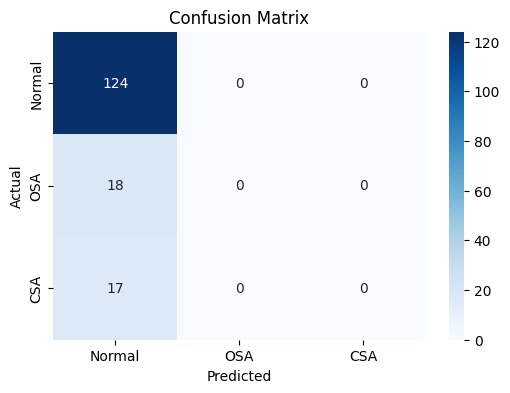

In [28]:
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

# Compute confusion matrix
cm = confusion_matrix(y_test, y_pred)

# Plot confusion matrix
plt.figure(figsize=(6, 4))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=["Normal", "OSA", "CSA"], yticklabels=["Normal", "OSA", "CSA"])
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()


Loaded .rec file successfully! Shape: (38996030,)
Segmented Data Shape: (51994, 750)
Loaded Labels Shape: (794,)
Corrected Data Shape: (794, 750)
Label Distribution: {np.int64(0): np.int64(618), np.int64(1): np.int64(91), np.int64(2): np.int64(85)}
Filtered Data Shape: (794, 750)
Class Weights: {0: np.float64(0.4284750337381916), 1: np.float64(2.8995433789954337), 2: np.float64(3.1127450980392157)}


c:\Users\Victus\AppData\Local\Programs\Python\Python311\Lib\site-packages\scipy\signal\_signaltools.py:2177: RuntimeWarning: invalid value encountered in cast
  return _sigtools._linear_filter(b, a, x, axis, zi)
c:\Users\Victus\AppData\Local\Programs\Python\Python311\Lib\site-packages\scipy\signal\_arraytools.py:103: RuntimeWarning: invalid value encountered in multiply
  ext = np.concatenate((2 * left_end - left_ext,
c:\Users\Victus\AppData\Local\Programs\Python\Python311\Lib\site-packages\scipy\signal\_arraytools.py:105: RuntimeWarning: overflow encountered in multiply
  2 * right_end - right_ext),
c:\Users\Victus\AppData\Local\Programs\Python\Python311\Lib\site-packages\scipy\signal\_arraytools.py:105: RuntimeWarning: invalid value encountered in subtract
  2 * right_end - right_ext),
c:\Users\Victus\AppData\Local\Programs\Python\Python311\Lib\site-packages\scipy\signal\_arraytools.py:103: RuntimeWarning: invalid value encountered in subtract
  ext = np.concatenate((2 * left_end - l

Epoch 1/30
40/40 ━━━━━━━━━━━━━━━━━━━━ 5s 58ms/step - accuracy: 0.7869 - loss: 0.0822 - val_accuracy: 0.7799 - val_loss: 0.0741
Epoch 2/30
40/40 ━━━━━━━━━━━━━━━━━━━━ 2s 49ms/step - accuracy: 0.7598 - loss: 0.0850 - val_accuracy: 0.7799 - val_loss: 0.0723
Epoch 3/30
40/40 ━━━━━━━━━━━━━━━━━━━━ 2s 49ms/step - accuracy: 0.7682 - loss: 0.0855 - val_accuracy: 0.7799 - val_loss: 0.0733
Epoch 4/30
40/40 ━━━━━━━━━━━━━━━━━━━━ 2s 49ms/step - accuracy: 0.7585 - loss: 0.0897 - val_accuracy: 0.7799 - val_loss: 0.0724
Epoch 5/30
40/40 ━━━━━━━━━━━━━━━━━━━━ 2s 49ms/step - accuracy: 0.7672 - loss: 0.0841 - val_accuracy: 0.7799 - val_loss: 0.0731
Epoch 6/30
40/40 ━━━━━━━━━━━━━━━━━━━━ 2s 49ms/step - accuracy: 0.7943 - loss: 0.0708 - val_accuracy: 0.7799 - val_loss: 0.0730
Epoch 7/30
40/40 ━━━━━━━━━━━━━━━━━━━━ 2s 49ms/step - accuracy: 0.7488 - loss: 0.0899 - val_accuracy: 0.7799 - val_loss: 0.0724
Epoch 8/30
40/40 ━━━━━━━━━━━━━━━━━━━━ 2s 51ms/step - accuracy: 0.7878 - loss: 0.0727 - val_accuracy: 0.7799 - v

c:\Users\Victus\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\Victus\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\Victus\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average,

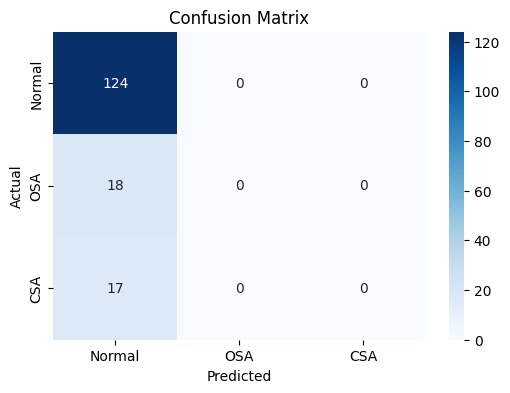

In [34]:
import numpy as np
from scipy.signal import butter, filtfilt
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, MaxPooling1D, LSTM, Dense, Dropout, BatchNormalization
from tensorflow.keras.optimizers import Adam
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.utils.class_weight import compute_class_weight
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras import backend as K

# Load .rec file
file_path = "../data/ISRUC_S3/RawData/RawData/1/1.rec"
try:
    data = np.fromfile(file_path, dtype=np.float32)
    print("Loaded .rec file successfully! Shape:", data.shape)
except Exception as e:
    print("Error reading .rec file:", e)

fs = 25  # Sampling rate
segment_length = 30 * fs  # 30s → 750 samples

# Trim excess samples to fit full epochs
required_samples = (len(data) // segment_length) * segment_length
data = data[:required_samples]

# Reshape into 30s segments
segments = data.reshape(-1, segment_length)
print("Segmented Data Shape:", segments.shape)  # Expected: (num_epochs, 750)

# Load labels
labels = np.loadtxt("../data/ISRUC_S3/RawData/RawData/1/1_1.txt", dtype=int)
labels = labels[:794]
print("Loaded Labels Shape:", labels.shape)

# Keep only enough samples for 794 epochs
required_samples = 794 * segment_length
data = data[:required_samples]  # Trim excess samples

# Reshape into (794, 750)
segments = data.reshape(-1, segment_length)
print("Corrected Data Shape:", segments.shape)

# Label Mapping
apnea_labels = np.copy(labels)
apnea_labels[np.isin(labels, [0, 2, 3])] = 0  # Normal: W, N2, N3
apnea_labels[np.isin(labels, [1])] = 1  # OSA: N1
apnea_labels[np.isin(labels, [5])] = 2  # CSA: REM

# Check label distribution
unique, counts = np.unique(apnea_labels, return_counts=True)
print("Label Distribution:", dict(zip(unique, counts)))

# Low-pass filter function
def butter_lowpass_filter(data, cutoff=0.5, fs=25, order=4):
    nyq = 0.5 * fs
    normal_cutoff = cutoff / nyq
    b, a = butter(order, normal_cutoff, btype='low', analog=False)
    return filtfilt(b, a, data)

# Apply filtering
filtered_segments = np.array([butter_lowpass_filter(seg) for seg in segments])
print("Filtered Data Shape:", filtered_segments.shape)

# Normalize data
filtered_segments = np.expand_dims(StandardScaler().fit_transform(filtered_segments), axis=-1)

# Train-test split (Ensure class balance)
X_train, X_test, y_train, y_test = train_test_split(filtered_segments, apnea_labels, 
                                                    test_size=0.2, random_state=42, stratify=apnea_labels)

# Compute class weights to handle imbalance
class_weights = compute_class_weight('balanced', classes=np.unique(y_train), y=y_train)
class_weights_dict = {i: weight for i, weight in enumerate(class_weights)}
print("Class Weights:", class_weights_dict)

# Focal Loss Function for Imbalance Handling
def focal_loss(alpha=0.25, gamma=2.0):
    def loss(y_true, y_pred):
        y_true = K.cast(y_true, tf.int64)
        y_pred = K.clip(y_pred, 1e-7, 1 - 1e-7)
        ce = K.sparse_categorical_crossentropy(y_true, y_pred)
        pt = K.exp(-ce)
        return K.mean(alpha * (1 - pt) ** gamma * ce)
    return loss

# CNN-LSTM Model
def build_model(input_shape):
    model = Sequential([
        Conv1D(filters=32, kernel_size=3, activation='relu', input_shape=input_shape),
        BatchNormalization(),
        MaxPooling1D(pool_size=2),
        Conv1D(filters=64, kernel_size=3, activation='relu'),
        BatchNormalization(),
        MaxPooling1D(pool_size=2),
        LSTM(64, return_sequences=True),
        LSTM(32),
        Dropout(0.3),
        Dense(64, activation='relu'),
        Dense(3, activation='softmax')  # 3 classes: Normal, OSA, CSA
    ])
    
    model.compile(optimizer=Adam(learning_rate=0.0005), loss=focal_loss(), metrics=['accuracy'])
    return model

# Train the model
model = build_model(input_shape=(750, 1))
history = model.fit(X_train, y_train, epochs=30, batch_size=16, validation_data=(X_test, y_test),
                    class_weight=class_weights_dict)

# Get model predictions
y_pred_probs = model.predict(X_test)
y_pred = np.argmax(y_pred_probs, axis=1)

# Print classification report
print("Classification Report:\n", classification_report(y_test, y_pred, target_names=["Normal", "OSA", "CSA"]))

# Compute accuracy
accuracy = accuracy_score(y_test, y_pred)
print("Model Accuracy:", accuracy)

# Compute confusion matrix
cm = confusion_matrix(y_test, y_pred)

# Plot confusion matrix
plt.figure(figsize=(6, 4))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=["Normal", "OSA", "CSA"], yticklabels=["Normal", "OSA", "CSA"])
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()
